In [13]:
import numpy as np
import pandas as pd

In [20]:
!ls | grep csv

cites.csv
content.csv
paper.csv


In [21]:
cites = pd.read_csv("cites.csv", delimiter="\t", header=None)
papers = pd.read_csv("paper.csv", delimiter="\t", header=None)
content = pd.read_csv("content.csv", delimiter="\t", header=None)

In [25]:
cites

,0,1
0,35,887
1,35,1033
2,35,1688
3,35,1956
4,35,8865
5,35,12576
6,35,15670
7,35,18582
8,35,27510
9,35,28290


In [26]:
import networkx as nx

In [27]:
G = nx.read_edgelist("cites.csv", delimiter="\t")

In [28]:
len(G.nodes())

2708

In [29]:
nx.is_connected(G)

False

In [31]:
H = max(nx.connected_component_subgraphs(G), key=len)

In [32]:
len(H.nodes())

2485

In [33]:
len(H.edges())

5069

In [1]:
import numpy as np
from scipy.ndimage.interpolation import rotate

from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import Concatenate
from keras.datasets import mnist

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# normalise
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [8]:
# dataset 1: add noise
T1 = x_train + np.random.normal(size=x_train.shape, loc=0, scale=0.5)
V1 = x_test + np.random.normal(size=x_test.shape, loc=0, scale=0.5)

# clip between 0 and 1
T1 = np.clip(T1, 0, 1)
V1 = np.clip(V1, 0, 1)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

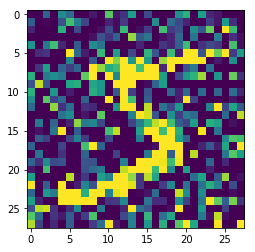

In [10]:
plt.imshow(T1[0])

In [7]:
# dataset 2: random rotations
T2 = np.array([rotate(input=x_train[y_train==y][np.random.choice(np.count_nonzero(y_train==y))], 
                      angle=np.random.rand()*360)[:28, :28] for y in y_train])
V2 = np.array([rotate(input=x_test[y_test==y][np.random.choice(np.count_nonzero(y_test==y))],
                      angle=np.random.rand()*360)[:28, :28] for y in y_test])

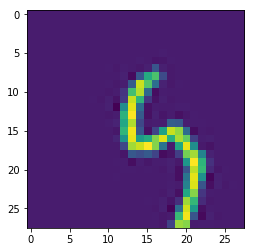

In [12]:
plt.imshow(T2[0].reshape(28, 28))

In [13]:
# reshape both datasets
input_size = np.prod(T1.shape[1:])
T1 = T1.reshape(T1.shape[0], input_size)
V1 = V1.reshape(V1.shape[0], input_size)
T2 = T2.reshape(T2.shape[0], input_size)
V2 = V2.reshape(V2.shape[0], input_size)

In [14]:
# input layers
input_1 = Input(shape=(input_size,))
input_2 = Input(shape=(input_size,))

# encoding layers
encoder_1 = Dense(256, activation="relu")
encoder_2 = Dense(256, activation="relu")

# concatenate
con = Concatenate(axis=1)

# shared latent space 
shared = Dense(2, activation="relu")

# decoding layers
decoder_1 = Dense(256, activation="relu")
decoder_2 = Dense(256, activation="relu")

# output layers
output_1 = Dense(input_size, activation="sigmoid")
output_2 = Dense(input_size, activation="sigmoid")

In [15]:
# output tensors
f_1 = output_1(decoder_1(shared(con([encoder_1(input_1), encoder_2(input_2)]))))
f_2 = output_2(decoder_2(shared(con([encoder_1(input_1), encoder_2(input_2)]))))

In [44]:
multi_view_autoencoder = Model([input_1, input_2], [f_1, f_2])

In [45]:
multi_view_autoencoder.compile(optimizer="sgd", loss="binary_crossentropy")

In [46]:
multi_view_autoencoder.fit([T1, T2], [x_train.reshape(x_train.shape[0], input_size), 
                                      x_train.reshape(x_train.shape[0], input_size)], 
                           batch_size=100, epochs=10, shuffle=True)

Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.5305 - dense_6_loss: 0.2654 - dense_7_loss: 0.2651     

In [47]:
Y1, Y2 = multi_view_autoencoder.predict([V1, V2])

In [48]:
i = 50

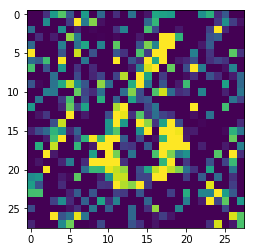

In [49]:
plt.imshow(V1[i].reshape(28, 28))

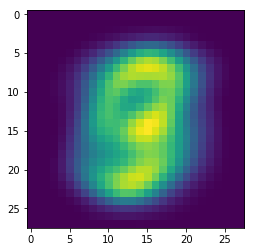

In [50]:
plt.imshow(Y1[i].reshape(28, 28))

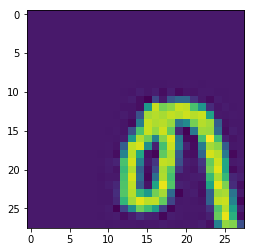

In [51]:
plt.imshow(V2[i].reshape(28, 28))

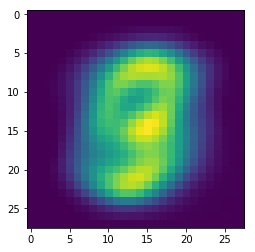

In [52]:
plt.imshow(Y2[i].reshape(28, 28))

In [53]:
encoder = Model([input_1, input_2], [shared(con([encoder_1(input_1), encoder_2(input_2)]))])

In [54]:
Ye = encoder.predict([V1, V2])

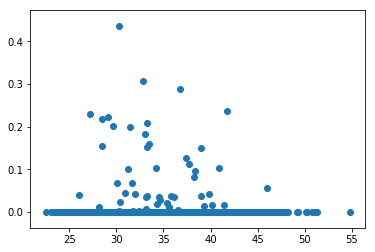

In [55]:
plt.scatter(Ye[:,0], Ye[:,1])

In [56]:
decoder_input = Input(shape=(2,))
decoder = Model(decoder_input, [output_1(decoder_1(decoder_input)), output_2(decoder_2(decoder_input))])

In [57]:
V1_decoded, V2_decoded = decoder.predict(Ye)

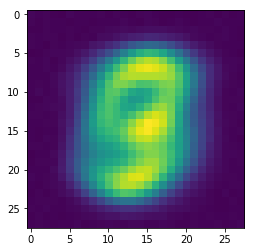

In [31]:
plt.imshow(V1_decoded[i].reshape(28, 28))

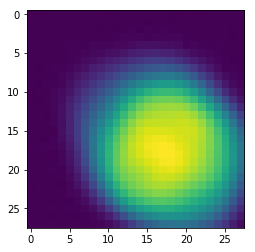

In [32]:
plt.imshow(V2_decoded[i].reshape(28, 28))